In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
master = pd.read_pickle("Combined_Social_Data_Pickle.pkl")

In [3]:
master.dtypes

Facebook                                       int64
Instagram                                      int64
Twitter                                        int64
Youtube                                        int64
age                                            int64
artist_name_x                                 object
artist_name_y                                 object
count_of_followers                           float64
created                               datetime64[ns]
created_12am-6am                               int64
created_12pm-6pm                               int64
created_6am-12pm                               int64
created_6pm-12am                               int64
crowdtangle_score                             object
description                                   object
description_length                             int64
facebook                                      object
genre_electronic                             float64
genre_hip_hop                                 

In [4]:
sorted(master.created)[:5]

[Timestamp('2006-04-02 19:09:00'),
 Timestamp('2006-04-03 16:40:00'),
 Timestamp('2006-04-04 16:33:00'),
 Timestamp('2006-04-04 16:56:00'),
 Timestamp('2006-05-02 19:17:00')]

In [5]:
sorted(master.created)[-5:]

[Timestamp('2019-07-06 16:55:14'),
 Timestamp('2019-07-06 16:55:14'),
 Timestamp('2019-07-06 16:55:14'),
 Timestamp('2019-07-06 16:55:14'),
 Timestamp('2019-07-06 16:55:14')]

In [6]:
#Only use data from 1/1/16 to 6/1/19
master = master[(master['created']>pd.to_datetime('01-01-2016')) & (master['created']<pd.to_datetime('06-01-2019'))]

In [7]:
len(master)

681571

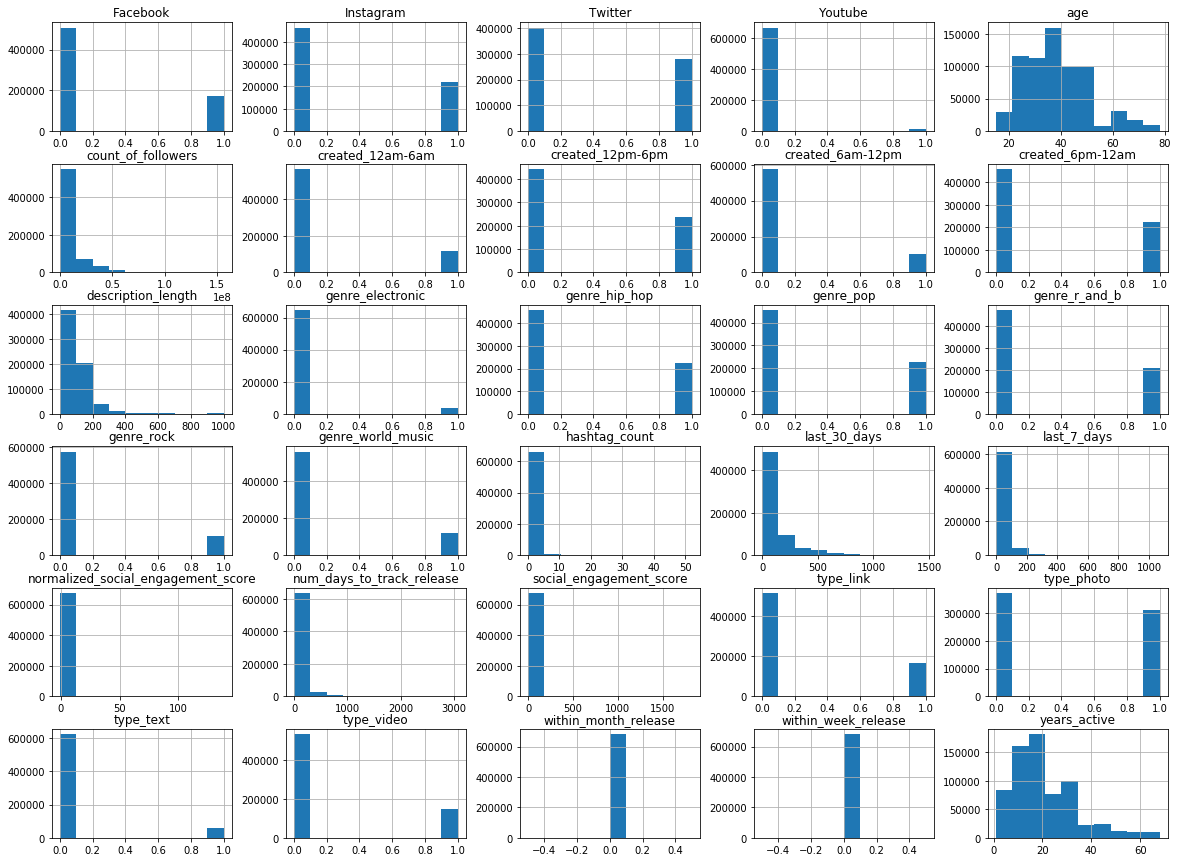

In [8]:
master.hist(figsize = (20,15))
plt.show()

In [9]:
# Check NAs for potential features
master.social_engagement_score.isna().sum()

5646

In [10]:
master.age.isna().sum()

0

In [11]:
master.normalized_social_engagement_score.isna().sum()

5646

In [15]:
# Normalize data
to_norm_list = ['count_of_followers', 'age', 'description_length', 
                'hashtag_count', 'last_30_days', 'last_7_days', 'num_days_to_track_release','years_active']

In [16]:
for feature in to_norm_list:
    master[feature] = preprocessing.scale(master[feature])

C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


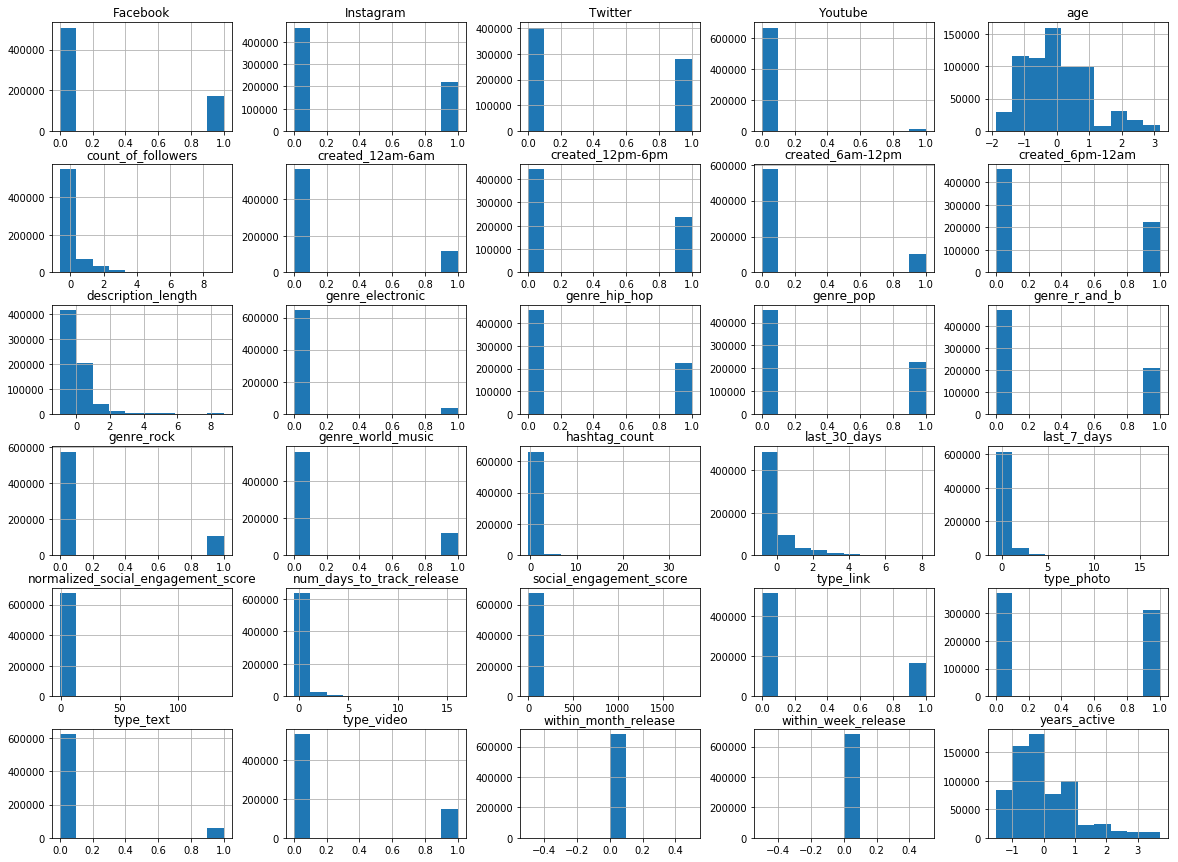

In [17]:
master.hist(figsize = (20,15))
plt.show()

In [18]:
master.head()

,Facebook,Instagram,Twitter,Youtube,age,artist_name_x,artist_name_y,count_of_followers,created,created_12am-6am,...,type_photo,type_text,type_video,within_month_release,within_week_release,years_active,youtube,social_platform,normalized_social_engagement_score,num_days_to_track_release
43,1,0,0,0,-0.995686,21Savage,21 Savage,NaN,2016-01-01 17:24:50,0,...,1,0,0,0,0,-1.214101,21 Savage,Facebook,NaN,0.142351
44,1,0,0,0,-0.995686,21Savage,21 Savage,NaN,2016-01-05 11:17:42,0,...,0,0,1,0,0,-1.214101,21 Savage,Facebook,NaN,0.120782
45,1,0,0,0,-0.995686,21Savage,21 Savage,NaN,2016-01-06 16:03:56,0,...,0,0,0,0,0,-1.214101,21 Savage,Facebook,NaN,0.115389
46,1,0,0,0,-0.995686,21Savage,21 Savage,NaN,2016-01-07 16:50:41,0,...,1,0,0,0,0,-1.214101,21 Savage,Facebook,NaN,0.109997
47,1,0,0,0,-0.995686,21Savage,21 Savage,NaN,2016-01-11 13:43:22,0,...,0,0,1,0,0,-1.214101,21 Savage,Facebook,NaN,0.088427


In [19]:
# Removing NaN of normalized_socila_engagement_score
master = master[pd.notnull(master['normalized_social_engagement_score'])]

In [20]:
master.shape

(675925, 42)

In [21]:
# Filling NaN of 6 features with 0
master['genre_electronic'].fillna(0,inplace = True)
master['genre_world_music'].fillna(0,inplace=True)
master['hashtag_count'].fillna(0,inplace=True)
master['last_30_days'].fillna(0,inplace=True)
master['last_7_days'].fillna(0,inplace=True)
master['time_since_last_post'].fillna(0,inplace=True)

In [23]:
master.isna().sum()

Facebook                                  0
Instagram                                 0
Twitter                                   0
Youtube                                   0
age                                       0
artist_name_x                             0
artist_name_y                             0
count_of_followers                        0
created                                   0
created_12am-6am                          0
created_12pm-6pm                          0
created_6am-12pm                          0
created_6pm-12am                          0
crowdtangle_score                      9179
description                           17121
description_length                        0
facebook                                  0
genre_electronic                          0
genre_hip_hop                             0
genre_pop                                 0
genre_r_and_b                             0
genre_rock                                0
genre_world_music               

In [24]:
# Drop unwanted features for modeling
master = master.drop(['crowdtangle_score', 'description', 'artist_name_x','artist_name_y','created','musicbrainz','social_platform','within_month_release',
       'within_week_release',], axis=1)

In [25]:
master.shape

(675925, 33)

In [26]:
prelim_features = master.columns

In [27]:
feature_list = ['count_of_followers','created_12am-6am','created_12pm-6pm','created_6am-12pm','created_6pm-12am','description_length','genre_electronic',
                'genre_hip_hop','genre_pop','genre_r_and_b','genre_rock','genre_world_music','hashtag_count','last_30_days',
               'last_7_days','time_since_last_post','type_link','type_photo','type_text','type_video','years_active','num_days_to_track_release']

In [28]:
main_feature_list = ['count_of_followers','description_length','hashtag_count','last_30_days',
               'last_7_days','time_since_last_post','years_active','num_days_to_track_release','normalized_social_engagement_score']

TypeError: Timedelta('2 days 20:50:23') is not a string

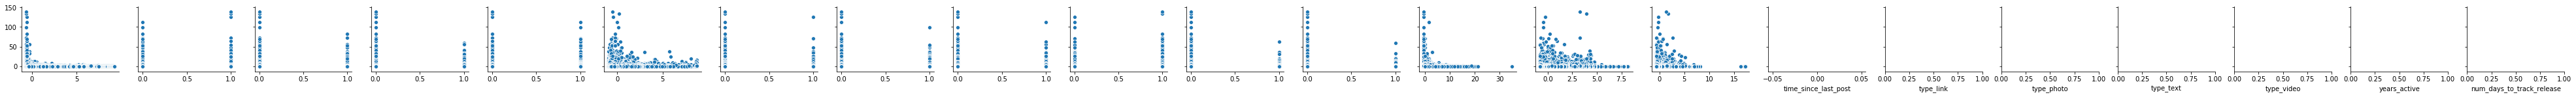

In [29]:
sns_plot  = sns.pairplot(data=master,y_vars='normalized_social_engagement_score',x_vars=feature_list)

In [30]:
import pandas as pd
import numpy as np

corr = master.corr()
corr.style.background_gradient(cmap='coolwarm')

,Facebook,Instagram,Twitter,Youtube,age,count_of_followers,created_12am-6am,created_12pm-6pm,created_6am-12pm,created_6pm-12am,description_length,genre_electronic,genre_hip_hop,genre_pop,genre_r_and_b,genre_rock,genre_world_music,hashtag_count,last_30_days,last_7_days,social_engagement_score,type_link,type_photo,type_text,type_video,years_active,normalized_social_engagement_score,num_days_to_track_release
Facebook,1,-0.399956,-0.492253,-0.0688464,0.0757326,0.107629,-0.160347,0.105037,0.113823,-0.0652531,0.0761306,-0.0479663,-0.119408,-0.0116888,-0.0395251,0.0818943,0.112554,0.021271,-0.101061,-0.0866583,-0.0108833,-0.103942,0.114237,-0.140015,0.0653845,0.0841346,-0.000767153,0.0446046
Instagram,-0.399956,1,-0.571839,-0.0799772,-0.0276026,0.0702501,-0.0687044,0.0487808,0.0373653,-0.023035,-0.0654401,-0.0104569,0.133571,-0.0649701,0.0312911,-0.0594948,-0.048933,0.0855819,-0.00972543,-0.0428342,-0.00969471,-0.389574,0.368548,-0.207317,0.102309,-0.0307675,-0.0170715,-0.0318415
Twitter,-0.492253,-0.571839,1,-0.0984334,-0.0466118,-0.173767,0.214235,-0.148388,-0.142884,0.0883027,0.00824955,0.0443056,-0.0130024,0.0681867,0.00619745,-0.0230604,-0.0539532,-0.0997532,0.114561,0.118754,-0.0156362,0.476125,-0.424489,0.328461,-0.207273,-0.051995,0.017141,-0.0144011
Youtube,-0.0688464,-0.0799772,-0.0984334,1,0.0236824,0.0508692,-0.0304365,0.039008,0.0283611,-0.03695,-0.0590657,0.0344543,-0.0314663,0.0152475,-0.0031293,0.0284922,0.00182045,2.58554e-05,-0.0671364,-0.00615725,0.146549,-0.0670592,-0.106891,-0.0356865,0.22382,0.0276242,-0.00138303,0.0210872
age,0.0757326,-0.0276026,-0.0466118,0.0236824,1,-0.0547101,-0.0553353,0.0556338,0.0533176,-0.0529963,0.122043,-0.126336,-0.0794753,-0.190916,-0.268542,0.482122,0.0975273,0.12345,0.0386398,0.00849598,-0.00720764,0.0390726,0.00505387,-0.0828274,0.00902183,0.946783,-0.218018,0.218217
count_of_followers,0.107629,0.0702501,-0.173767,0.0508692,-0.0547101,1,-0.0168828,0.0323336,-0.00946995,-0.0120059,-0.088616,-0.0898907,0.0716106,0.113079,0.224458,-0.137909,0.0218781,-0.0421794,-0.00873512,-0.0134365,-0.000881798,-0.0901048,0.0636851,-0.0758708,0.0686625,0.0236176,-0.118128,-0.0941422
created_12am-6am,-0.160347,-0.0687044,0.214235,-0.0304365,-0.0553353,-0.0168828,1,-0.332817,-0.193594,-0.316972,-0.0546123,0.0115086,0.077611,-0.028307,0.0168393,-0.0703621,-0.0379103,-0.0388092,0.120419,0.133655,-0.00431774,0.0979895,-0.0835092,0.0962633,-0.0667288,-0.0534118,0.0105408,-0.0321981
created_12pm-6pm,0.105037,0.0487808,-0.148388,0.039008,0.0556338,0.0323336,-0.332817,1,-0.311158,-0.509461,0.0373626,-0.00534113,-0.0526996,0.0238535,-0.0101351,0.0613994,0.0206529,0.0264151,-0.0883479,-0.0794345,0.00115485,-0.0784439,0.0552486,-0.0561525,0.0533104,0.0476887,-0.0119513,0.0229562
created_6am-12pm,0.113823,0.0373653,-0.142884,0.0283611,0.0533176,-0.00946995,-0.193594,-0.311158,1,-0.296345,0.0298846,0.0131419,-0.0480019,-0.00620081,-0.024211,0.0710909,0.00149355,-0.00555191,-0.0117145,-0.0163288,0.0093905,-0.0494197,0.0425132,-0.0239624,0.0165286,0.0551686,-0.0118858,0.027796
created_6pm-12am,-0.0652531,-0.023035,0.0883027,-0.03695,-0.0529963,-0.0120059,-0.316972,-0.509461,-0.296345,1,-0.0170159,-0.0139183,0.028027,0.00328135,0.0153577,-0.0604269,0.00834238,0.00862218,0.00196371,-0.0141869,-0.00491538,0.0388914,-0.0216601,-0.00192198,-0.0132206,-0.0478921,0.0127988,-0.0187917


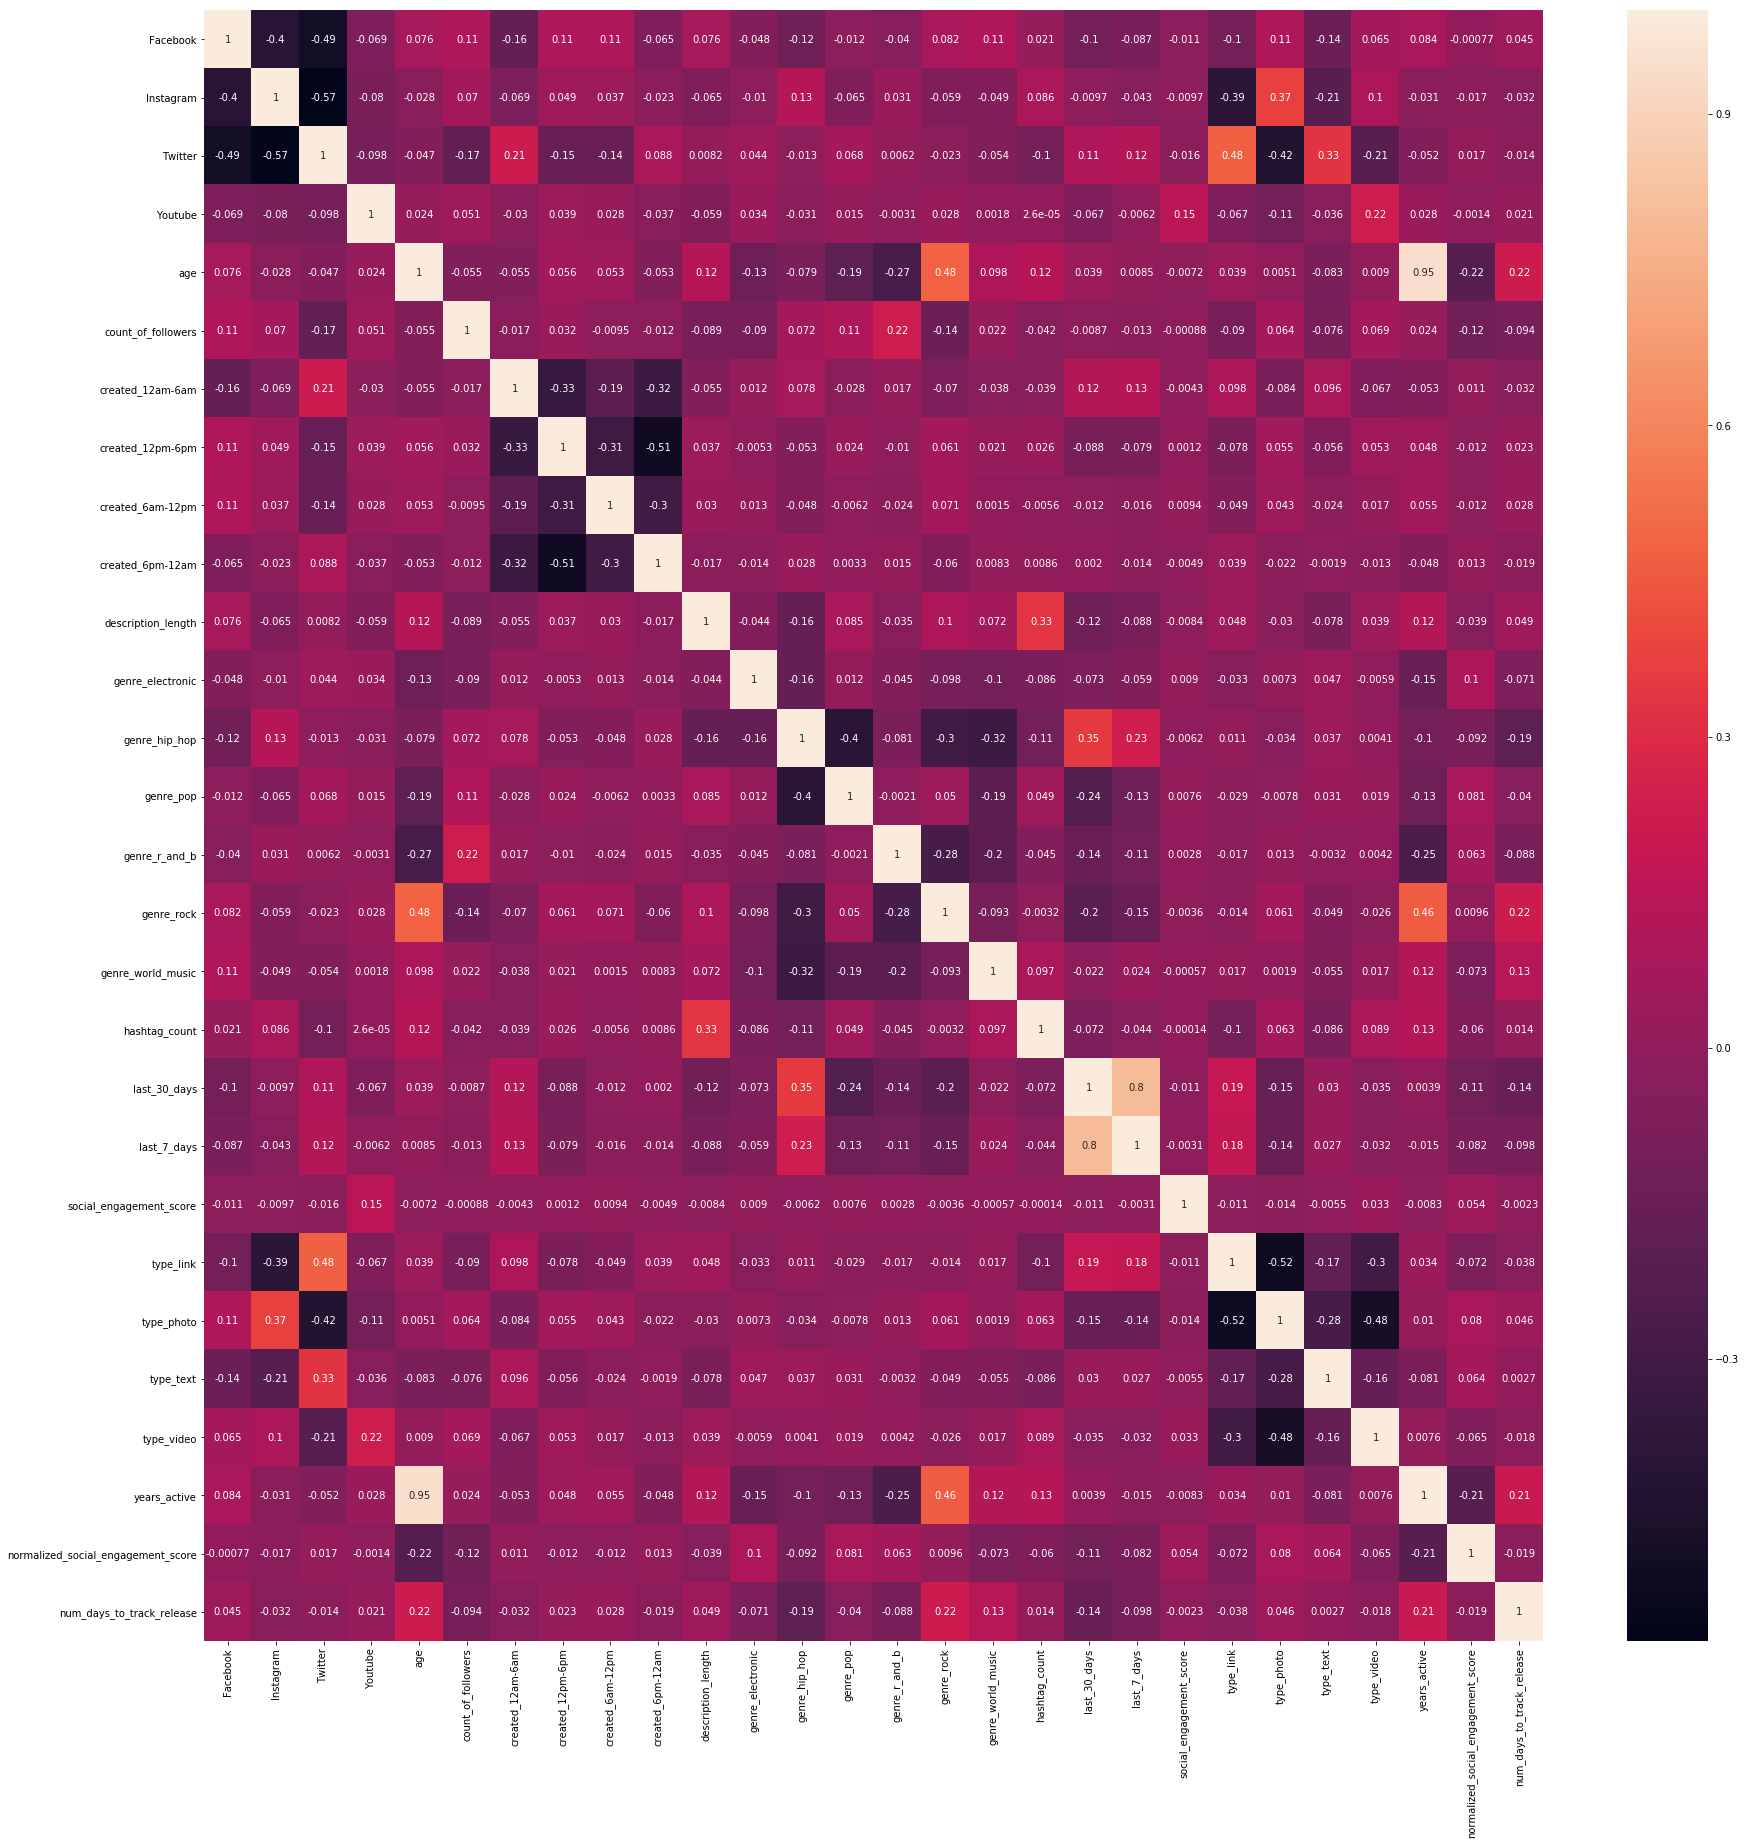

In [31]:
## correlation heatmap - No strong correlation observed except for years_Active and age
fig, axs = plt.subplots(figsize = (30, 30))
sns.heatmap(master.corr(), annot = True)
## - No strong correlation observed except for years_Active and age - Need to take a decision on this during feature selection

In [33]:
# Base model for FB
df_fb = master[master['Facebook'] == 1]
df_fb.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score','time_since_last_post'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_fb.drop('normalized_social_engagement_score', axis=1), df_fb['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
fb_regressor = LinearRegression()
fb_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = fb_regressor.predict(X_test)
print(mean_squared_error(y_pred,y_test))
print(fb_regressor.coef_)

C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


0.9979451445610029
[-2.24210245e-01 -1.67968602e-01 -2.32782869e+11 -4.55924155e+11
 -3.82892794e+11 -4.10681668e+11 -3.40527446e-02  1.12298514e-01
  3.67705630e-02  1.98923695e-02  8.94451665e-02  3.67437403e-02
  6.13816698e-03 -2.22316934e-02 -1.18250334e-03 -4.84966645e-02
 -1.29679845e+11 -1.71971153e+11 -4.63396090e+10 -1.52018634e+11
  8.16821246e-02 -2.91447283e-02]


In [36]:
# Base model for Instagram
df_insta = master[master['Instagram'] == 1]
df_insta.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score','time_since_last_post'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_insta.drop('normalized_social_engagement_score', axis=1), df_insta['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
insta_regressor = LinearRegression()
insta_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = insta_regressor.predict(X_test)
print(mean_squared_error(y_pred,y_test))
print(insta_regressor.coef_)

C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


0.7274499552099992
[-3.22067061e-01 -1.17159434e-01  7.01748212e+10  1.00200473e+11
  7.79468294e+10  9.53728445e+10 -5.93435327e-03  6.48140384e-02
 -1.66678067e-01 -2.73937297e-02 -7.92778372e-02  1.75168133e-01
 -1.35590011e-01 -6.03043368e-02 -2.00022225e-02 -1.06138379e-01
  1.36220294e+09 -2.17958854e+11  6.10351562e-05 -2.17958854e+11
 -5.73635133e-02  1.24906268e-02]


In [37]:
# Base model for Twitter
df_twt = master[master['Twitter'] == 1]
df_twt.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score','time_since_last_post'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_twt.drop('normalized_social_engagement_score', axis=1), df_twt['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
twt_regressor = LinearRegression()
twt_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = twt_regressor.predict(X_test)
print(mean_squared_error(y_pred,y_test))
print(twt_regressor.coef_)

C:\Users\Phani\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


0.670407789108827
[-2.80266901e-01 -9.70976855e-02  2.86353334e+11  2.85106148e+11
  1.87070949e+11  3.13123094e+11 -1.77624410e-02 -2.20294132e-03
 -6.22258393e-02 -1.57430123e-02  6.79982450e-02  5.37628202e-02
 -3.18219472e-02 -3.00146959e-03  8.55162050e-02 -5.86298047e-02
  3.73676938e+12  2.99859286e+12  2.95227989e+12  2.37843150e+12
  8.51368893e-02 -1.18638279e-02]


In [38]:
# Base model for Youtube
df_yt = master[master['Youtube'] == 1]
df_yt.drop(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'facebook', 'instagram', 'twitter', 'youtube', 'social_engagement_score','time_since_last_post'], inplace = True, axis = 1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_yt.drop('normalized_social_engagement_score', axis=1), df_yt['normalized_social_engagement_score'], test_size = 0.2, random_state = 0)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Multiple Linear Regression to the Training set
yt_regressor = LinearRegression()
yt_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = yt_regressor.predict(X_test)
print(mean_squared_error(y_pred,y_test))
print(yt_regressor.coef_)

0.12109924913990565
[ 9.69647346e-02 -2.72302869e-02 -3.96985504e-03 -7.16428732e-03
  1.17333250e-02 -1.00291905e-03  1.74064819e-02 -5.49197190e-03
 -8.27128873e-03  2.42442588e-02  1.02886203e-02 -2.47449241e-02
  1.27231000e-02  1.21430643e-17 -4.52075907e-02  3.83683773e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.13253834e-01 -3.40228564e-03]


C:\Users\Phani\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phani\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Phani\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
